# MNIST Classification

**Import packages**

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Define a fully connected Neural Network
We define a very simple fully connected neural network. It is a subclass of torch.nn.Module. <br>
When extending torch.nn.Module we need to define two methods:
- `__init__` method:
it is the constructor of the class and is called only once, when instantiating the neural network. It initializes the network's architecture by initializing all network layers and other components. It is where you define the structure of the network, such as layers, activation functions, and any other components required for computation.
-`forward` method
is called when you pass input data through the network. The forward method specifies the sequence of operations that are applied to the input data. It describes how the input data flow through the various layers to produce the final output.

In [3]:
# define neural network
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(28*28, 512)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(512, 512)
        self.act2 = nn.ReLU()

        self.output_layer = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, 28, 28) => (batch_size, 28*28)

        # first layer (input is x, output is x1)
        x1 = self.lin1(x)
        x1 = self.act1(x1)

        # second layer (input is x1, output is x2)
        x2 = self.lin2(x1)
        x2 = self.act2(x2)

        # third/output layer (input is x2, output is logits)
        logits = self.output_layer(x2)
        return logits


## Dataset

In [43]:
from torchvision import datasets, transforms
import os

# Verifica che i file esistano
raw_folder = './data/MNIST/raw'
print("File nella cartella raw:")
for file in os.listdir(raw_folder):
    print(f"  - {file}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

# Prova a caricare
try:
    train_dataset = datasets.MNIST('./data', train=True, download=False, transform=transform)
    print(f"✓ MNIST train dataset - num samples: {len(train_dataset)}")
    
    test_dataset = datasets.MNIST('./data', train=False, download=False, transform=transform)
    print(f"✓ MNIST test dataset - num samples: {len(test_dataset)}")
except Exception as e:
    print(f"Errore: {e}")

File nella cartella raw:
  - t10k-images-idx3-ubyte.gz
  - train-images-idx3-ubyte.gz
  - train-labels-idx1-ubyte.gz
  - t10k-labels-idx1-ubyte.gz
Errore: Dataset not found. You can use download=True to download it


In [44]:
import torch
from torch.utils.data import Dataset
import gzip
import numpy as np

class CustomMNIST(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        # Carica immagini
        with gzip.open(images_path, 'rb') as f:
            self.images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
        
        # Carica labels
        with gzip.open(labels_path, 'rb') as f:
            self.labels = np.frombuffer(f.read(), np.uint8, offset=8)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype('float32') / 255.0
        label = self.labels[idx]
        
        # Converti in tensor e aggiungi dimensione canale
        image = torch.tensor(image).unsqueeze(0)  # (28, 28) -> (1, 28, 28)
        
        # Applica la normalizzazione
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Usa il dataset
from torchvision import transforms

# Solo normalizzazione (ToTensor già fatto nel __getitem__)
transform = transforms.Normalize((0.1307,), (0.3081,))

train_dataset = CustomMNIST(
    './data/MNIST/raw/train-images-idx3-ubyte.gz',
    './data/MNIST/raw/train-labels-idx1-ubyte.gz',
    transform=transform
)

test_dataset = CustomMNIST(
    './data/MNIST/raw/t10k-images-idx3-ubyte.gz',
    './data/MNIST/raw/t10k-labels-idx1-ubyte.gz',
    transform=transform
)

print(f"✓ MNIST train dataset - num samples: {len(train_dataset)}")
print(f"✓ MNIST test dataset - num samples: {len(test_dataset)}")

# Test: carica un'immagine
image, label = train_dataset[0]
print(f"✓ Image shape: {image.shape}")  # Dovrebbe essere torch.Size([1, 28, 28])
print(f"✓ Label: {label}")

✓ MNIST train dataset - num samples: 60000
✓ MNIST test dataset - num samples: 10000
✓ Image shape: torch.Size([1, 28, 28])
✓ Label: 5


### Plot one sample from dataset

In [45]:
image, label = train_dataset[100]

In [46]:
image.shape

torch.Size([1, 28, 28])

In [47]:
label

np.uint8(5)

In [48]:
# dataset returns one sample at a time
# In our case one sample corresponds to a Tuple: (Image, Target Label)
# Image is a tensor with shape [1, 28, 28]
# Label is an integer representing the class of the image

print(type(train_dataset[100]))
print(len(train_dataset[100]))

image, label = train_dataset[100]
print("image: ", image.shape, type(image))
print("label: ", label, type(label))

<class 'tuple'>
2
image:  torch.Size([1, 28, 28]) <class 'torch.Tensor'>
label:  5 <class 'numpy.uint8'>


In [49]:
image.shape

torch.Size([1, 28, 28])

In [50]:
image[0].shape

torch.Size([28, 28])

In [51]:
image = image.view(28,28)
image.shape

torch.Size([28, 28])

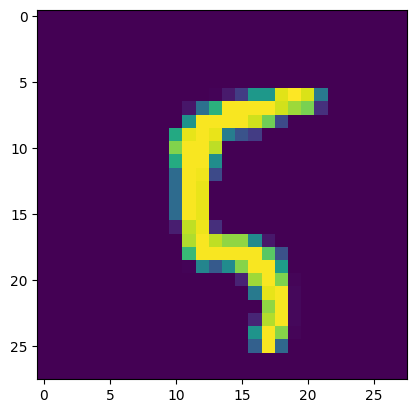

In [53]:
# plot one sample normalized

import matplotlib.pyplot as plt
plt.imshow(image.numpy())  # numpy array 28x28

## Dataloader
Dataloader reads from the dataset and returns batches of data. We need to specify at least:
- `dataset`: torch.utils.data.Dataset object from which the DataLoader fetch data
- `batch_size`: number of sample in a batch, e.g. 128, choose the maximum that the GPU can fit

Other parameters are:
- `shuffle`: boolean, whether we want to shuffle the data samples
- `drop_last`: boolean, whether the last batch, which may have fewer samples than the specified batch size, should be included or dropped



In [54]:
batch_size = 128  # we define here the batch size: number of samples processed before the model is updated
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , drop_last=False)
print(f"batch size: {batch_size}")

batch size: 128


## Training

In [55]:
# function for training
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # model to train mode

    # ITERATE DATALOADER: train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        #  SINGLE OPTIMIZATION STEP IS PERFORMED ON A BATCH!
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# test
# function for evaluation
def test(model, device, test_loader):
    model.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [58]:
# Usa MPS per Mac (Apple Silicon) o CPU come fallback
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using MPS (Metal Performance Shaders) - Apple GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("✓ Using CUDA - NVIDIA GPU")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

# training hyperparameters
lr = 0.01
num_epochs = 5
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")

#########
# MODEL #
#########
model = NeuralNetwork(num_classes=10)
model = model.to(device)

#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

✓ Using MPS (Metal Performance Shaders) - Apple GPU
lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 468


In [59]:
%%time
for epoch in range(1, num_epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329612
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.765130
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.272953
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.402543
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.350140
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.350037
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.245429
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.242869
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.180852
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.171246

Test set: Average loss: 0.1692, Accuracy: 9472/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.347149
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.093997
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.089008
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.070041
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.107576
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.204547
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.163901
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.161367
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.100613
T